# 若干种类的支持向量机之练习(Multiclass Support Vector Machine exercise)

本次练习你将会：

- 实现“全向量式(fully-vectorized)”的 SVM **损失函数（loss function）**
- 实现 SVM 的** 分析梯度（analytic gradient）**“全向量式”表达式
- 使用数值梯度（numerical gradient）来检验实现之正确与否
- 使用验证集来**调整学习率和正则化强度（译者注：和前面的任务类似）**
- 通过**SGD**来**优化**损失函数
- **可视化**最终的学习权重

In [2]:
import random 
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] ='nearest'
plt.rcParams['image.cmap'] ='gray'

%load_ext autoreload
%autoreload 2


## CIFAR-10 数据加载和预处理

In [3]:
# 加载原始的CIFAR-10数据
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
# 检查训练集和测试集的大小
print("训练集输入的大小："+str(X_train.shape))
print("训练集标签的大小："+str(y_train.shape))
print("测试集输入的大小："+str(X_test.shape))
print("测试集标签的大小："+str(y_test.shape))

训练集输入的大小：(50000L, 32L, 32L, 3L)
训练集标签的大小：(50000L,)
测试集输入的大小：(10000L, 32L, 32L, 3L)
测试集标签的大小：(10000L,)


There are 10 classes


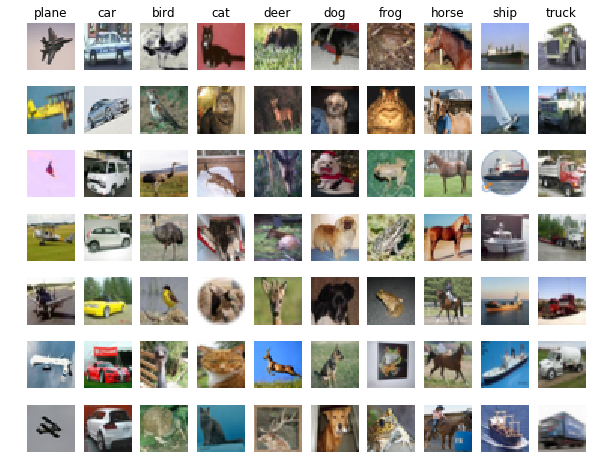

In [7]:
# 将数据集中每个类中抽取几幅来显示
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
print("There are %d classes"%num_classes)

samples_per_class = 7 # 对每个类进行7个采样
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i*num_classes+y+1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i==0:
            plt.title(cls)
plt.show()            


In [ ]:
# 将数据划归为训练集，验证集，测试集。另外，我们也创建了一个小的开发集（development 
# set）作为训练数据的一个子集。我们可以使用该开发集还使我们的模型运行更快
num_training = 49000 
num_validation = 1000
num_test = 1000
num_dev = 500

# 从与原始训练集中提取 num_validation 个点作为验证集
mask = range(num_training, num_training+num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# 从原始的训练集中提取 num_train 个点作为训练集
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# 相较于原先增加一个开发集（development set），其是训练集中的一个子集
mask = random.choice(num_training, num_dev, replace =False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# 将原始测试集中的前 num_test 个点作为测试集
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print("训练集数据大小："+str(X_train.shape))
print("训练集标签大小："+str(y_train.shape))
print("验证集数据大小："+str(X_val.shape))
print("验证集标签大小："+str(y_val.shape))
print("测试集数据大小："+str(X_test.shape))
print("测试集标签大小："+str(y_test.shape))

In [ ]:
# 预处理环节之：将图像转换成成行（向量）
# （译者注：吴恩达的机器学习中将图像转换成为列向量）
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_testm.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# 作为一种安全检查，输出数据的大小
print("训练集数据大小："+str(X_train.shape))
print("验证集数据大小："+str(X_val.shape))
print("测试集数据大小："+str(X_test.shape))
print("开发集数据大小："+str(X_dev.shape))


In [ ]:
# 预处理环节之：将去平均图像
# 首先：基于训练数据，来计算出图像的均值
mean_image = np.mean(X_train, axis= 0)
print(mean_image[:10])
plt.figure(figsize=(4, 4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) #将平均图像可视化
plt.show()

In [ ]:
# 让后，从训练数据和测试数据中减去平均图像
X_train -=mean_image
X_val-=mean_image
X_test -= mean_image
X_dev -= mean_image


In [ ]:
# 再次，增加一个为 1 的维度，这样我们的 SVM 纸用考虑优化一个单一的权重举证 W
X_train = np.hstack([X_train, np.ones((X_trin.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## SVM 分类器

这一部分的代码，你需要在 **cs231n/classifiers/linear_svm.py** 中完善和实现。

如下，函数`compute_loss_navie` 用以评估若干种 SVM 的算是函数。

In [ ]:
# 评估损失函数的原始实现
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# 生成一个随机的 SVM 权重矩阵，其中都是比较小的数
W = np.random.randn(3073, 10)*0.0001

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.00001)
print("loss:%f"%(loss, ))

上面函数返回给`grad` 目前是全零。在函数`svm_loss_naive`中实现SVM的成本函数的梯度。
为了检查实现梯度的正确性，可以在数值上将估计和计算得到的损失函数的梯度进行比较。

In [ ]:
# 一旦实现了梯度，需要对其进行检查

# 计算 W 的损失值和梯度
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# 随机选择几个下降的维度来计算梯度，将其和分析计算的梯度进行对比。
# 理论上应当在所有维度上两者相一致
from cs231n.gradient_check import grad_check_sparse

f = lambda w:svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# 开启正则化来对梯度进行检查（忘记了正则化梯度？好好回顾）
loss, grad = svm_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w:svm_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f,W, grad)


### 问题1:

在梯度检查的过程中可能会遇到维度不匹配的情况，这是由于什么原因造成的呢？这是一个值得关注的问题吗？在一个维度梯度检查实效这样的简单实例能够找出？*提示： SVM 损失函数是否可微（the SVM loss function is not strictly speaking differentiable*）*

**问题1回答：**在某些点损失函数是不可微的。例如，**ReLu**函数$f(x)=max(0, x)$,在$x=0$处就不可微。

梯度的计算式为，$\frac{df(x)}{dx}=\frac{f(x+h)-f(x-h)}{2*h}$。使用该定义式，代入数值得到$\frac {h}{2}$处的梯度$f'(\frac{h}{2})=\frac {3}{4}$,然而使用梯度计算式得到的结果为$f'(\frac {h}{2})=1$。可见在$x=0$附近，存在着这种不一致的情况。



In [ ]:
# 接下来实现函数 svm_loss_verctorized: 先实现计算损失
# 一会儿再实现梯度计算
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print("Naive loss: %e "%loss_naive)
print("计算耗时： %fs"%(toc-tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized

tic = time.time()
loss_vectorized = svm_loss_vectorized(W, X_dec, y_dev, 0.00001)
toc = time.time()
print("Vectorized loss: %e"%loss_vectorized)
print("计算耗时：%fs"%(toc-tic))

# 计算出的算是应当相同，向量化的实现应该更快些
print("两者相差:%f"%(loss_naive-loss_vectorized))

In [ ]:
# 完成 svm_loss_vectorized 的实现，以向量化的方式计算损失函数的梯度

tic= time.time()
_, grad_naive = svm_loss_naive(W, X_dev,  y_dev, 0.00001)
toc=time.time()
print("Naive loss and gradient: %e %f"%(_, grad_naive))
print("计算耗时 %fs"%(toc-tic))

tic = time.time() 
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print("Vectorized loss and gradient: %e %f"%(_, grad_vectorized))
print("计算耗时 %fs"%(toc-tic))

# 两种方式的实现，损失值是一个单一的数值，所以其很好比较。
# 而得到的梯度是一个矩阵，所以我们使用 Frobenius 范数来比较

difference = np.linalg.norm(grad_naive - grad_vectorized, ord = 'fro')
print("差值：%f"%difference)

### 随机梯度下降( Stochastic Gradient Descent)

对于损失(loss)和梯度（gradient），我们已经有了向量化且高效的表达式。并且梯度计算的结果和数值梯度（定义式得到的梯度）一致。所以，接下来使用SGD 来最小化损失。

In [ ]:
# 在文件 linear_classifier.py 中，实现 SGD 
# 函数名为 LinearClassifier.train() 
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate = 1e-7, reg = 5e4,
                     num_iters=1500, verboss=True)
toc = time.time()
print("计算耗时 %fs"%(toc-tic))

In [ ]:
# 作为一种验证策略，绘制损失随迭代次数变化的曲线
plt.plot(loss_hist)
plt.xlabel("Iteration number")
plt.ylabel("Loss value")
plt.show()

In [ ]:
# 编写 LinearSVM.predict 函数并在训练集和验证集傻瓜评估其表现
y_train_pred = svm.predict(X_train)
print("训练正确率:"+str(np.mean(y_train == y_train_pred)))
y_val_pred = svm.pred(X_val)
print("验证正确率："+str(np.mean(y_val ==y_val_pred)))

In [ ]:
# 使用验证集来调整超参数（学习率和正则化强度）
# 你应当测试多组不同范围的学习率和正则化强度测桉树
# 正确的情况你将会在验证集上，得到大约0.4的正确率

learning_rates = [1.4e-7, 1.5e-7, 1.6e-7]
regularization_strengeths = [(1+i*0.1)*1e4 for i in range(-3, 3)] + [(2+0.1*i)*1e4 for i in range(-3, 3)]]
# 结果为形如 (learning_rate, regularization_strength) 的元组
# 
